# Visually Exploring Data Using Seaborn

This session will build on the previous session that introduced the
Seaborn library, using it to visualise data and do some exploratory
analysis.

We are using [Australian weather
data](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package),
taken from [Kaggle](https://kaggle.com). This dataset is used to build
machine learning models that predict whether it will rain tomorrow,
using data about the weather every day from 2007 to 2017. To download
the data, click <a href="data/weatherAUS.csv" download>here</a>.

The objective from this session is to:

-   Understand how to describe data quantitatively and when different
    methods are appropriate
-   Visualise data as a means of describing it
-   Show how to visualising data is a shortcut for describing central
    tendency, spread, uncertainty etc.
-   Introduce ideas around describing and visualising relationships
    between variables

In [1]:
# import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control some deprecation warnings in seaborn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)

# import the dataset
df = pd.read_csv('data/weatherAUS.csv')

First, we will take a subset of the data, using Australia’s five biggest
cities. This gives us a more manageable dataset to work with.

In [2]:
# subset of observations from five biggest cities
big_cities = (
    df.loc[df['Location'].isin(['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney'])]
    .copy()
)

## Exploratory Data Analysis

What does exploratory data analysis aim to achieve? What are you looking
for when visualising data? **Patterns, shapes, signals!**

When we describe a variable, or a sample of that variable, we are
interested in understanding the characteristics of the observations. The
starting point for doing this is describing the value that the data
tends to take (central tendency), and how much it tends to deviate from
its typical value (spread). Visualising the distribution of a variable
can tell us these things (approximately), and can tell us about the
shape of the data too.

The “central tendency” is the average or most common value that a
variable takes. Mean, median, and mode are all descriptions of the
central tendency.

-   Mean - Sum of values in a sample divided by the total number of
    observations.
-   Median - The midpoint value if the sample is ordered from highest to
    lowest.
-   Mode - The most common value in the sample[1].

The mean is the most common approach, but the mean, median, and mode
choice are context-dependent. Other approaches exist, too, such as the
geometric mean[2].

[1] The mode value is generally most useful when dealing with
categorical variables.

[2] The geometric mean multiplies all values in the sample and takes the
$n$th root of that multiplied value. It can be useful when dealing with
skewed data or data with very large ranges, and when dealing with rates,
proportions etc. However it can’t handle zeros or negative values.

In [3]:
# mode rainfall by location
big_cities.groupby('Location')['Rainfall'].agg(pd.Series.mode)

Location
Adelaide     0.0
Brisbane     0.0
Melbourne    0.0
Perth        0.0
Sydney       0.0
Name: Rainfall, dtype: float64

In [4]:
# mode location
big_cities['Location'].agg(pd.Series.mode)

0    Sydney
Name: Location, dtype: object

In [5]:
# mode location using value counts
big_cities['Location'].value_counts().iloc[0:1]

Location
Sydney    3344
Name: count, dtype: int64

In [6]:
# mean rainfall by location
np.round(big_cities.groupby('Location')['Rainfall'].mean(), decimals=2)

Location
Adelaide     1.57
Brisbane     3.14
Melbourne    1.87
Perth        1.91
Sydney       3.32
Name: Rainfall, dtype: float64

In [7]:
# median rainfall by location
big_cities.groupby('Location')['Rainfall'].median()

Location
Adelaide     0.0
Brisbane     0.0
Melbourne    0.0
Perth        0.0
Sydney       0.0
Name: Rainfall, dtype: float64

In [8]:
# geometric mean max temperature by location
big_cities.groupby('Location')['MaxTemp'].apply(lambda x: np.exp(np.log(x).mean()))

Location
Adelaide     21.888697
Brisbane     26.152034
Melbourne    19.972352
Perth        24.320203
Sydney       22.570993
Name: MaxTemp, dtype: float64

The values across the different measures of central tendency are not
always the same. In this case, the mean and median differs massively.

**Questions**:

-   Why is that? Why would the median rainfall be zero for all five
    cities?
-   Does this matter? How would it change our understanding of the
    rainfall variable?

Distributions can tell us more. We have simulated three different
distributions that have slightly different shapes, to see how their mean
and median values differ.

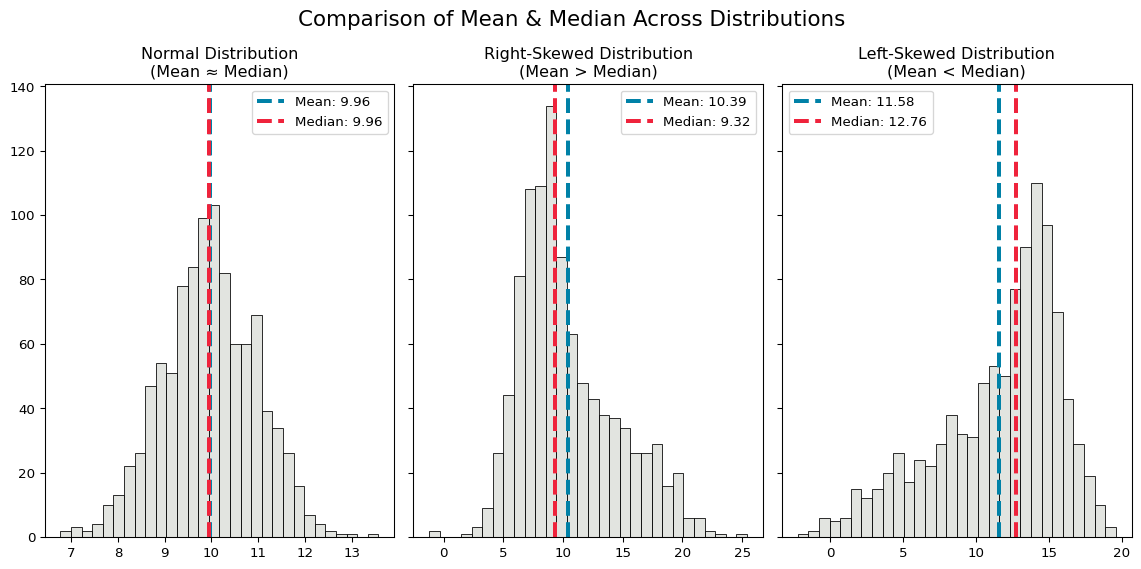

In [9]:
# generate distributions
np.random.seed(123)
normal_dist = np.random.normal(10, 1, 1000)
right_skewed_dist = np.concatenate([np.random.normal(8, 2, 600), np.random.normal(14, 4, 400)])
left_skewed_dist = np.concatenate([np.random.normal(14, 2, 600), np.random.normal(8, 4, 400)])

# set figure size
plt.rcParams['figure.figsize'] = (12, 6)

# function for calculating summary statistics and plotting distributions
def plot_averages(ax, data, title):
    mean = np.mean(data)
    median = np.median(data)
    
    sns.histplot(data, color="#d9dcd6", bins=30, ax=ax)
    ax.axvline(mean, color="#0081a7", linewidth=3, linestyle="--", label=f"Mean: {mean:.2f}")
    ax.axvline(median, color="#ef233c", linewidth=3, linestyle="--", label=f"Median: {median:.2f}")
    ax.set_title(title)
    ax.set_ylabel('')
    ax.legend()

# plot distributions
fig, axes = plt.subplots(1, 3, sharey=True)

plot_averages(axes[0], normal_dist, "Normal Distribution\n(Mean ≈ Median)")
plot_averages(axes[1], right_skewed_dist, "Right-Skewed Distribution\n(Mean > Median)")
plot_averages(axes[2], left_skewed_dist, "Left-Skewed Distribution\n(Mean < Median)")

plt.suptitle("Comparison of Mean & Median Across Distributions", fontsize=16)
plt.tight_layout()
plt.show()

The mean and median of the normal distribution are identical, while the
two skewed distributions have slightly different means and medians.

-   The mean is larger than the median when the distribution is
    right-skewed, and the median is larger than the mean when it is
    left-skewed.
    -   When the distribution is skewed, the median value will be a
        better description of the central tendency, because the mean
        value is more sensitive to extreme values (and skewed
        distributions have longer tails of extreme values).

These differences point to another important factor to consider when
summarising data - the spread or deviation of the sample.

-   How do we measure how a sample is spread around the central
    tendency?
    -   Standard deviation and variance quantify spread.
    -   Variance, the average squared difference between observations
        and the mean value, measures how spread out a sample is.
    -   Standard deviation is the square root of the variance. It’s
        easier to interpret because it’s in the same units as the
        sample.

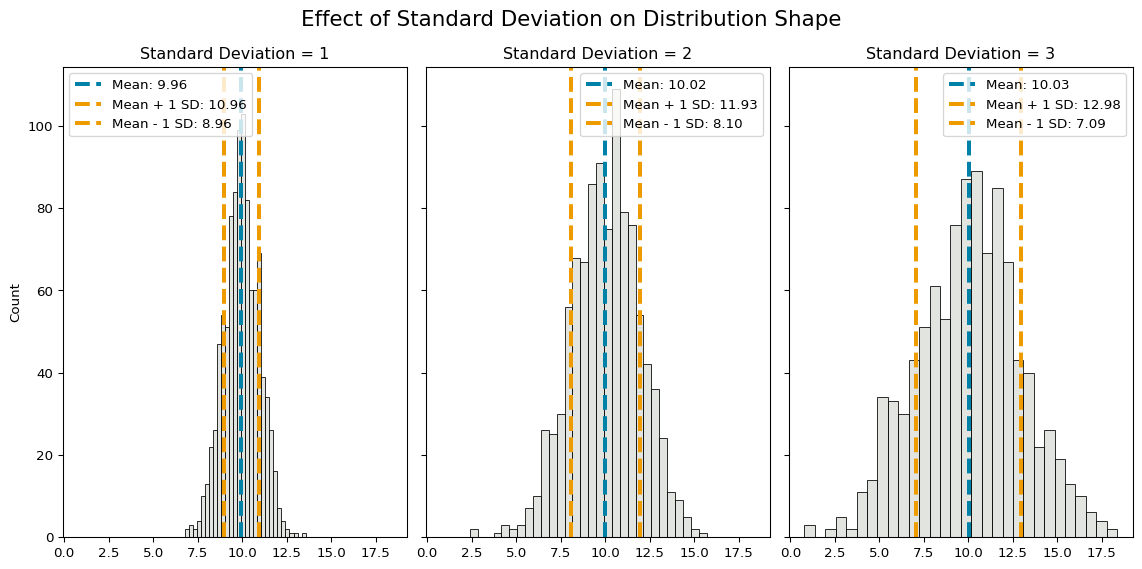

In [10]:
# generate distributions
np.random.seed(123)
mean = 10
std_devs = [1, 2, 3]
distributions = [np.random.normal(mean, std_dev, 1000) for std_dev in std_devs]

# function for calculating summary statistics and plotting distributions
def plot_spread(ax, data, std_dev, title):
    mean = np.mean(data)
    std_dev = np.std(data)

    sns.histplot(data, color="#d9dcd6", bins=30, ax=ax)
    ax.axvline(mean, color="#0081a7", linewidth=3, linestyle="--", label=f"Mean: {mean:.2f}")
    ax.axvline(mean + std_dev, color="#ee9b00", linewidth=3, linestyle="--", label=f"Mean + 1 SD: {mean + std_dev:.2f}")
    ax.axvline(mean - std_dev, color="#ee9b00", linewidth=3, linestyle="--", label=f"Mean - 1 SD: {mean - std_dev:.2f}")
    ax.set_title(f"{title}")
    ax.legend()

# plot distributions
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True)

for i, std_dev in enumerate(std_devs):
    plot_spread(axes[i], distributions[i], std_dev, f"Standard Deviation = {std_dev}")

plt.suptitle("Effect of Standard Deviation on Distribution Shape", fontsize=16)
plt.tight_layout()
plt.show()

As standard deviation increases, the spread of values around the mean
increases.

We can compute various summary statistics that describe a sample (mean,
median, standard deviation, kurtosis etc. etc.), or we can just
visualise it!

Visualising distributions is a good starting point for understanding a
sample. It can quickly and easily tell you a lot about the data.

## Exploring Australian Weather

### Visualising Single Variables

We can start by visualising the distribution of rainfall and sunshine in
Australia’s big cities, including dashed lines to show the mean and
median values.

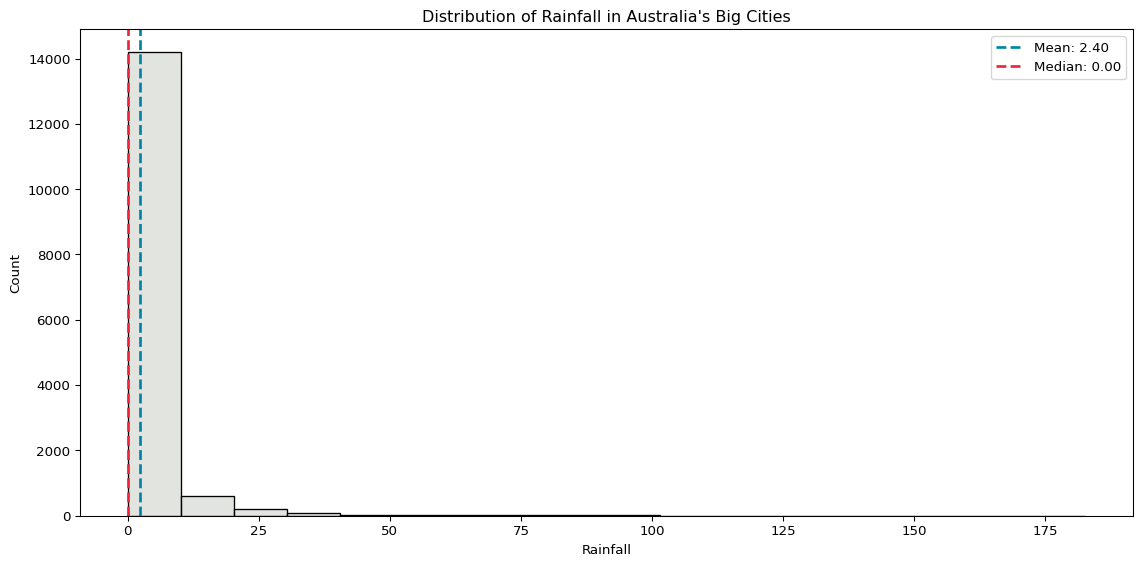

In [11]:
# plot distribution of rainfall
rainfall_mean = np.mean(big_cities['Rainfall'])
rainfall_median = np.median(big_cities['Rainfall'].dropna())

sns.histplot(data=big_cities, x='Rainfall', binwidth=10, color="#d9dcd6")
plt.axvline(rainfall_mean, color="#0081a7", linestyle="--", linewidth=2, label=f"Mean: {rainfall_mean:.2f}")
plt.axvline(rainfall_median, color="#ef233c", linestyle="--", linewidth=2, label=f"Median: {rainfall_median:.2f}")

plt.title("Distribution of Rainfall in Australia's Big Cities")

plt.legend()
plt.tight_layout()
plt.show()

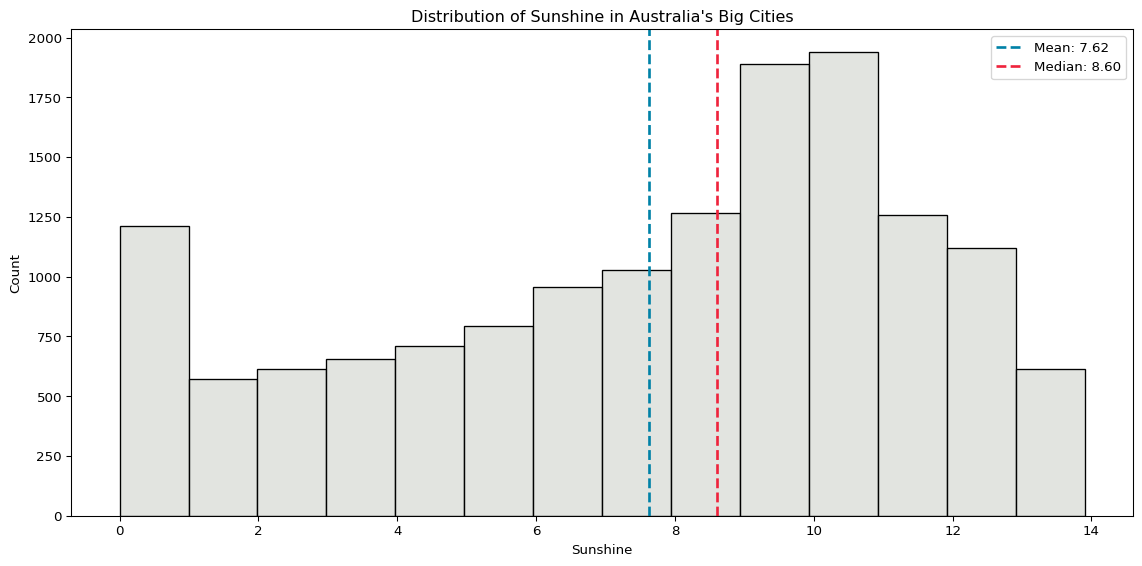

In [12]:
# plot distribution of sunshine
sunshine_mean = np.mean(big_cities['Sunshine'])
sunshine_median = np.median(big_cities['Sunshine'].dropna())

sns.histplot(data=big_cities, x='Sunshine', binwidth=1, color="#d9dcd6")
plt.axvline(sunshine_mean, color="#0081a7", linestyle="--", linewidth=2, label=f"Mean: {sunshine_mean:.2f}")
plt.axvline(sunshine_median, color="#ef233c", linestyle="--", linewidth=2, label=f"Median: {sunshine_median:.2f}")

plt.title("Distribution of Sunshine in Australia's Big Cities")

plt.legend()
plt.tight_layout()
plt.show()

Rainfall is very skewed, because the vast majority of days have zero
rainfall. The distribution of sunshine is a little more evenly spread.

While these two plots require a little more code, we can get most of
what we want with a lot less just using `sns.histplot()` on its own. For
example, plotting the distribution of maximum temperature, without all
the other bells and whistles, already tells us a lot.

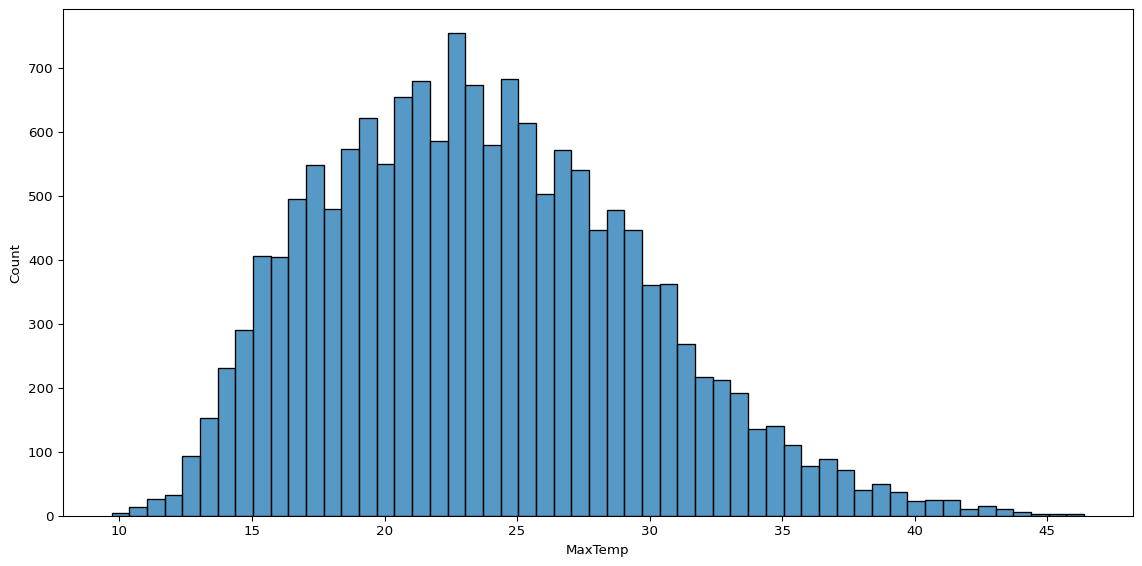

In [13]:
sns.histplot(data=big_cities, x='MaxTemp')
plt.tight_layout()
plt.show()

We can also look at the distribution of observations split by group,
using `sns.countplot()`. Below, we see the number of observations per
city in our subset.

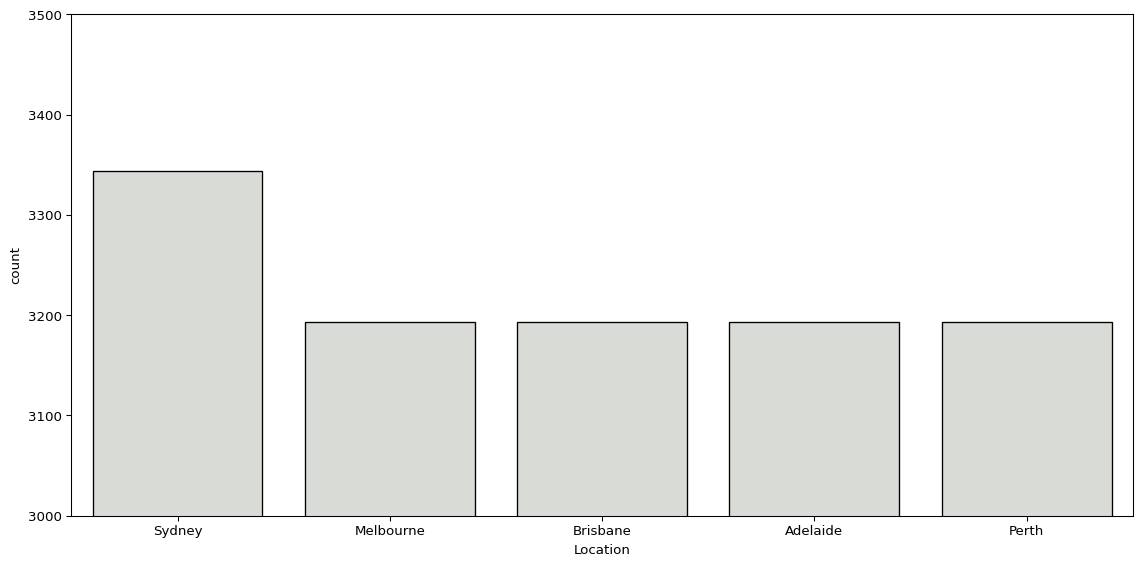

In [14]:
sns.countplot(big_cities, x='Location', color="#d9dcd6", edgecolor='black')
plt.ylim(3000, 3500)
plt.tight_layout()
plt.show()

Similarly, we can look at the number of days with or without rain the
next day.

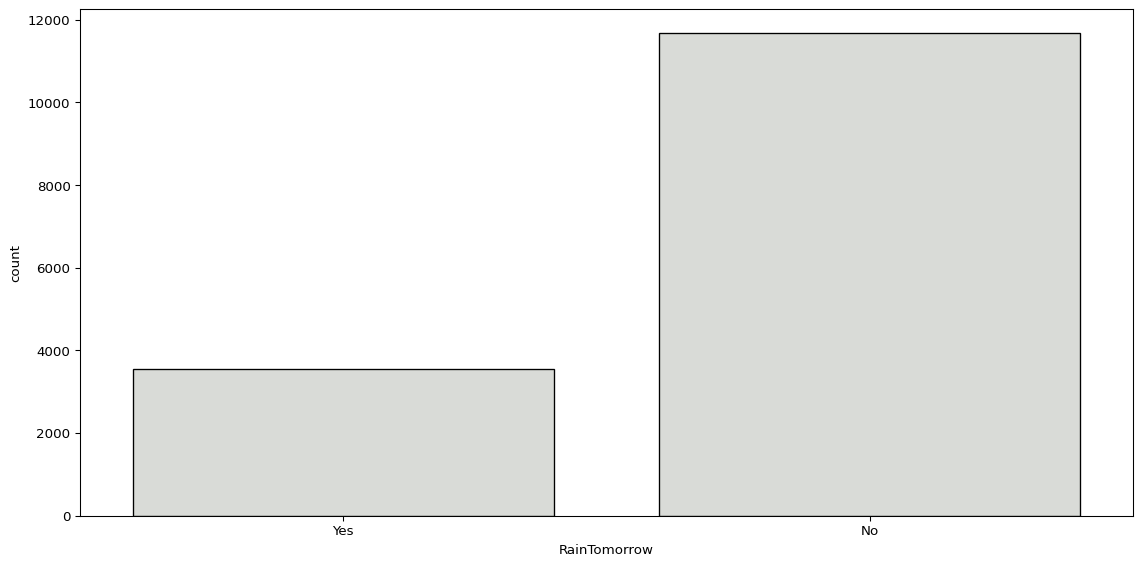

In [15]:
sns.countplot(big_cities, x='RainTomorrow', color="#d9dcd6", edgecolor='black')
plt.tight_layout()
plt.show()

However, it’s worth noting there is a simpler approach to this, just
using `pd.DataFrame.value_counts()`.

In [16]:
big_cities['RainTomorrow'].value_counts()

RainTomorrow
No     11673
Yes     3543
Name: count, dtype: int64

### Visualising Multiple Variables

We will often want to know how values of a given variable change based
on the values of another. This may not indicate a relationship, but it
helps us better understand our data. There are lots of ways we can do
this.

We can use `sns.barplot()` to plot the average hours of sunshine by
location.

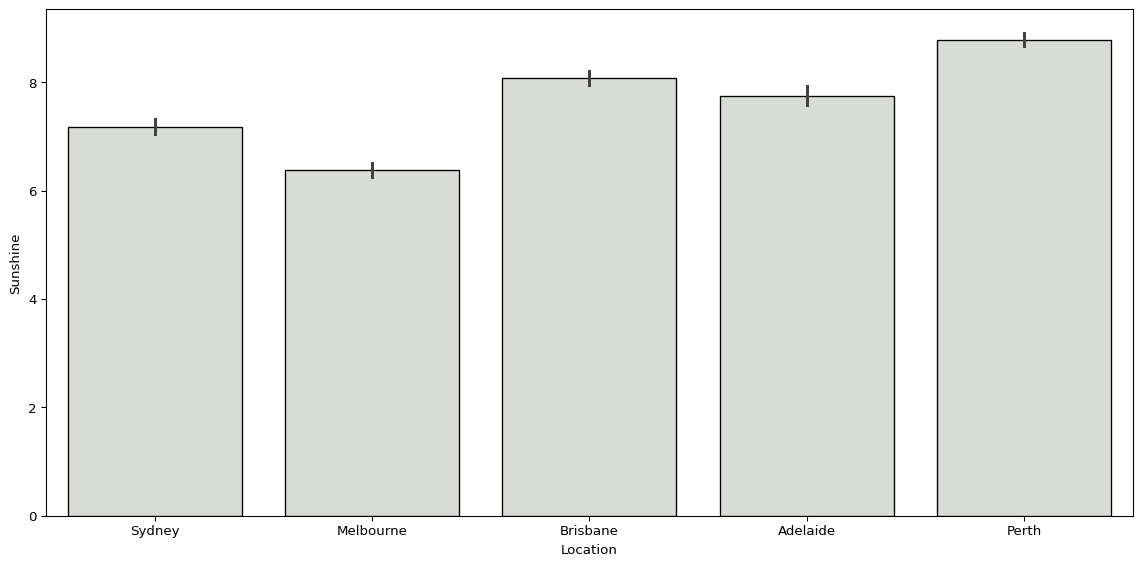

In [17]:
sns.barplot(big_cities, x='Location', y='Sunshine', color="#d9dcd6", edgecolor='black')
plt.tight_layout()
plt.show()

Or we could use `sns.boxplot()`, visualising the distribution of maximum
temperatures and humidity at 3pm by location.

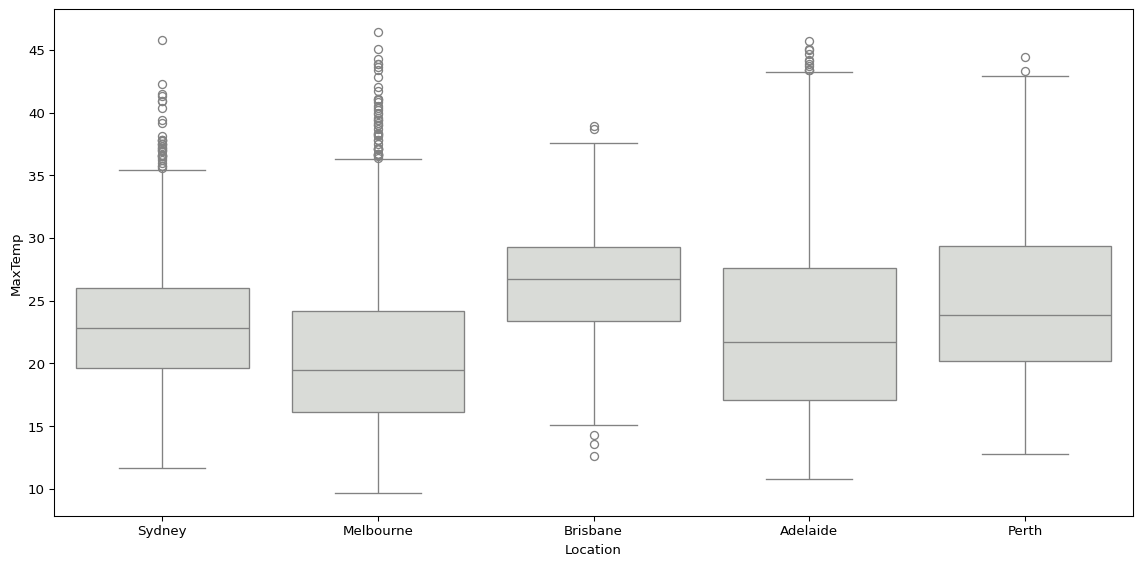

In [18]:
sns.boxplot(big_cities, x='Location', y='MaxTemp', color="#d9dcd6")
plt.tight_layout()
plt.show()

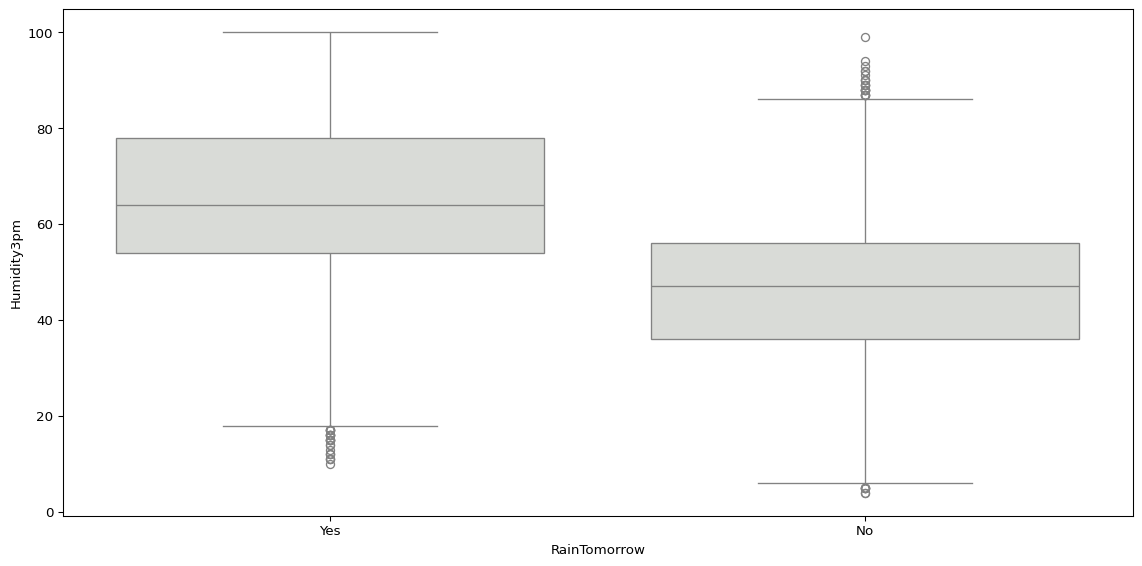

In [19]:
sns.boxplot(data=big_cities, x='RainTomorrow', y='Humidity3pm', color="#d9dcd6")
plt.tight_layout()
plt.show()

Another way we can compare the distribution of values by groups is using
`sns.kdeplot()`, which visualises a [kernel-density
estimation](https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde).

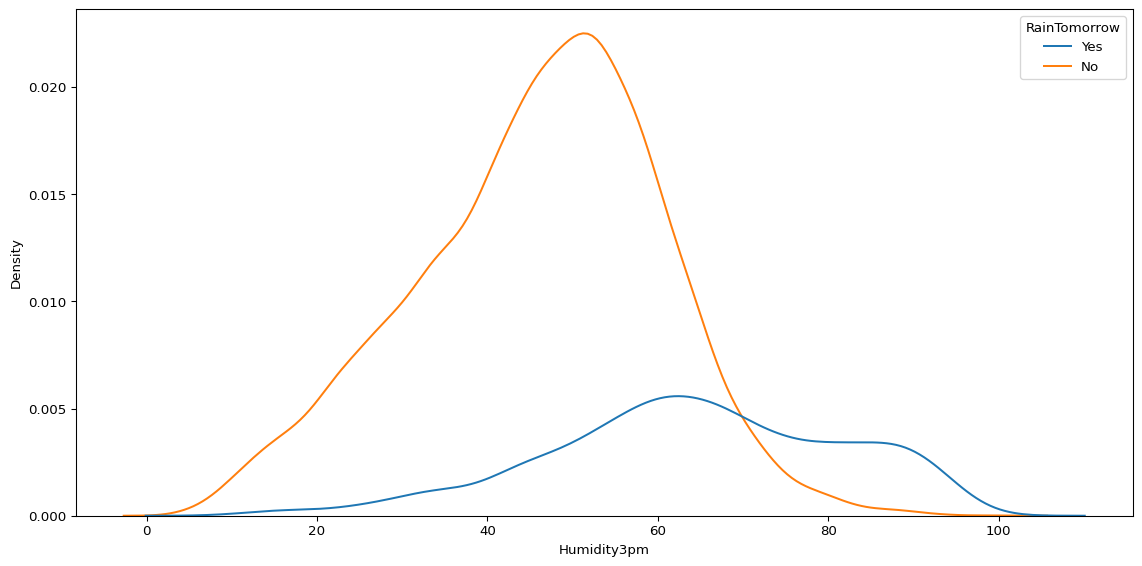

In [20]:
sns.kdeplot(data=big_cities, x='Humidity3pm', hue='RainTomorrow')
plt.tight_layout()
plt.show()

While there are lots of different ways we can quickly and easily compare
two variables, or compare the value of a variable by groups, the right
approach will always be context-dependent. It will all depend on what
questions you have about your data, and which variables you are
interested in.

If you have lots of questions about multiple variables, one way of
exploring quickly is `sns.pairplot()`.

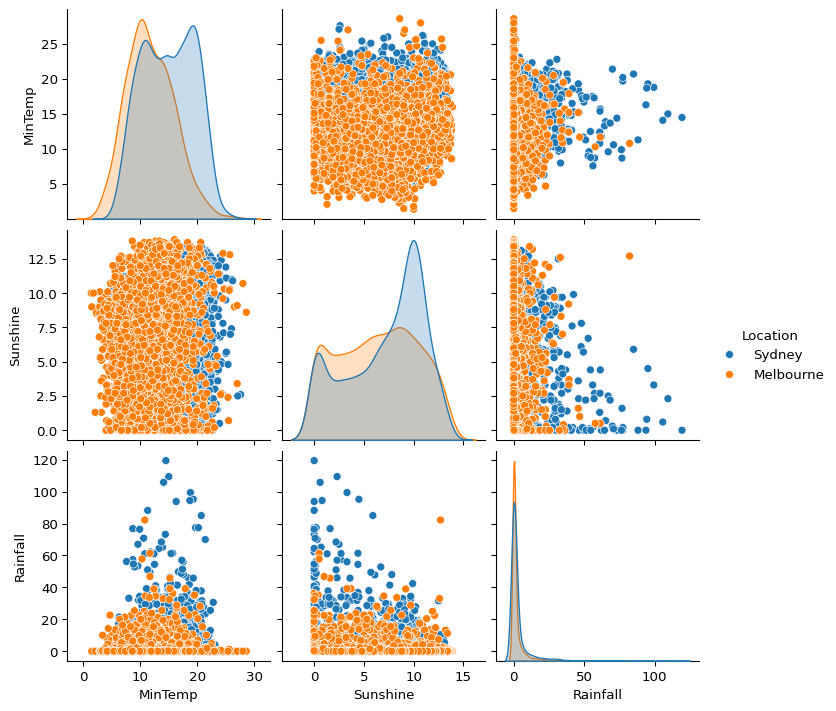

In [21]:
biggest_cities = big_cities.loc[big_cities["Location"].isin(['Sydney', 'Melbourne'])]
sns.pairplot(
    biggest_cities,
    vars=['MinTemp', 'Sunshine', 'Rainfall'],
    hue='Location'
    )

plt.show()

I tend to struggle to infer much from complex plots like this, so I
prefer to create separate plots using `sns.scatterplot()`.

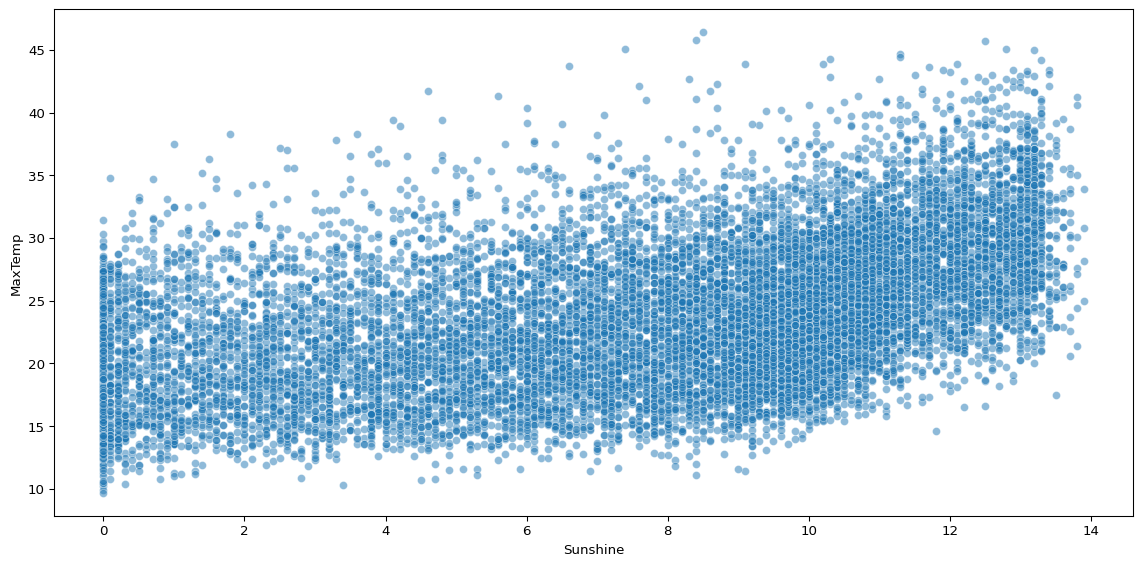

In [22]:
sns.scatterplot(big_cities, x='Sunshine', y='MaxTemp', alpha=0.5)

plt.tight_layout()
plt.show()

Scatterplots can help you visualise how two continuous variables vary
together. The above plot shows that sunshine hours are positively
associated with maximum temperature, but there is significant noise.

If we compare this with a scatterplot visualising the association
between two variables that should have a strong relationship, such as
humidity at 9am and 3pm, we can see the difference.

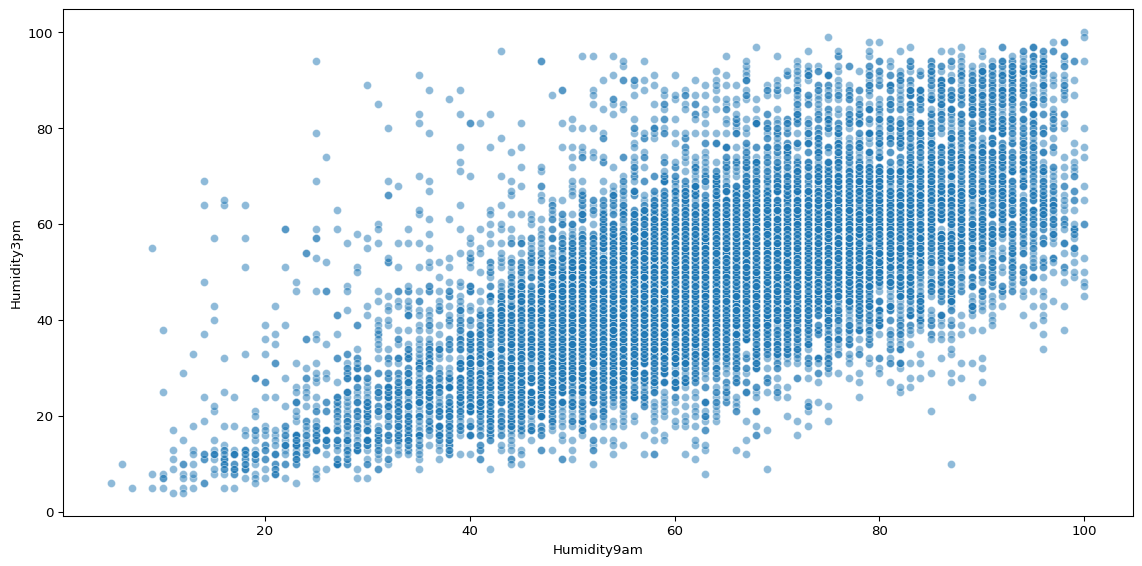

In [23]:
sns.scatterplot(big_cities, x='Humidity9am', y='Humidity3pm', alpha=0.5)

plt.tight_layout()
plt.show()

There is still plenty of noise, but as humidity at 9am increases, it is
clear that humidity at 3pm is likely to increase.

Another change we might make, to reduce the noise, is adding grouping
structures to our scatterplot. Perhaps much of the noise in the sunshine
scatterplot is because we are looking at data across many cities.

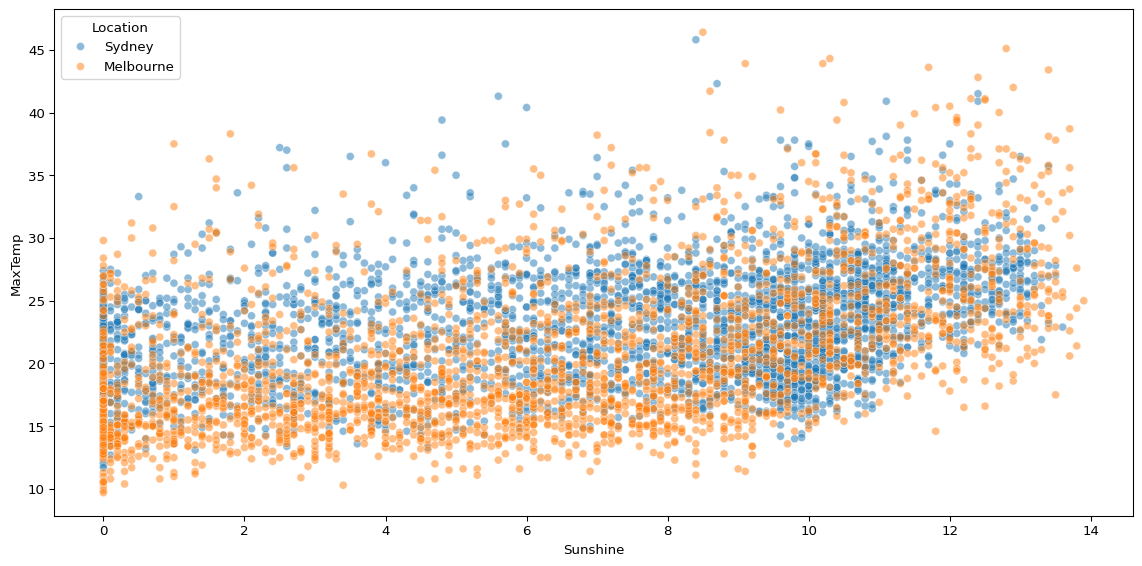

In [24]:
sns.scatterplot(biggest_cities, x='Sunshine', y='MaxTemp', hue='Location', alpha=0.5)

plt.tight_layout()
plt.show()

When we compare just two cities, there still appears to be significant
noise.

Sometimes you might need to do some more complex operations to transform
the data before visualising it, in order to ask more specific questions.
For example, you might want to compare how the total rainfall per day
has varied over time in the data.

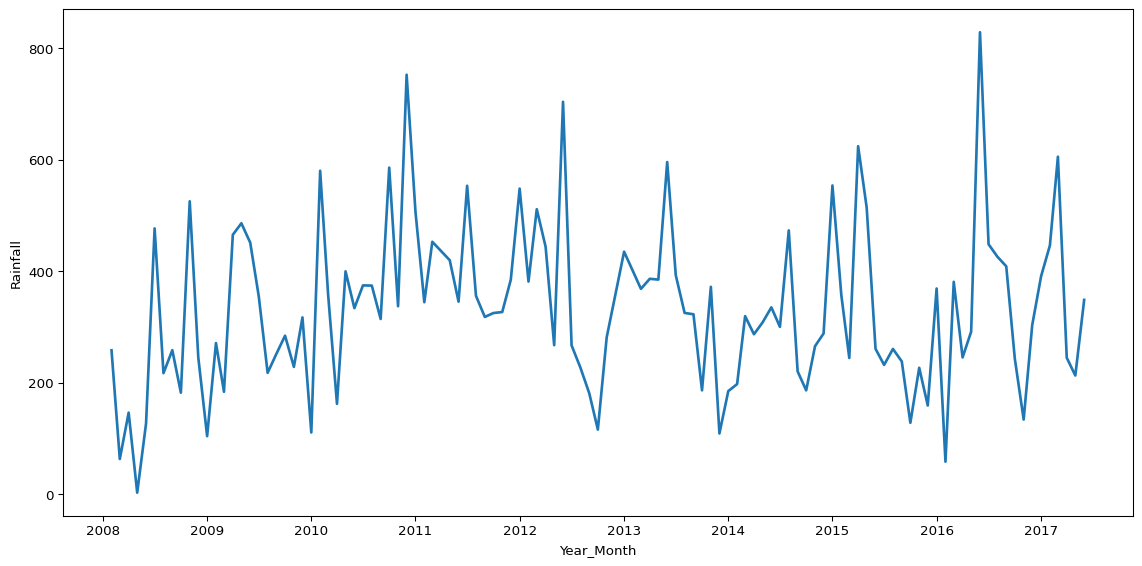

In [25]:
(
    big_cities
    # convert date to datetime
    .assign(Date=pd.to_datetime(big_cities['Date']))
    # create year-month column
    .assign(Year_Month=lambda x: x['Date'].dt.to_period('M'))
    # group by year-month and calculate sum of rainfall
    .groupby('Year_Month')['Rainfall'].sum()
    # convert year-month index back to column in dataframe
    .reset_index()
    # create year-month timestamp for plotting
    .assign(Year_Month=lambda x: x['Year_Month'].dt.to_timestamp()) 
    # pass df object to seaborn lineplot
    .pipe(lambda df: sns.lineplot(data=df, x='Year_Month', y='Rainfall', linewidth=2))
)

plt.tight_layout()
plt.show()

The above plot leverages an approach called [method
chaining](https://tomaugspurger.net/posts/method-chaining/), where we
call multiple methods one after the other in the same operation[1].
Method chaining syntax is sometimes a little easier to follow, and you
don’t have to create new objects for every operation, which can be a
tidier way to work.

We can do the same to transform the data and visualise the mean average
sunshine per month.

[1] This may not be something you feel comfortable with yet, but it is
something you may come across, and could explore in the future.

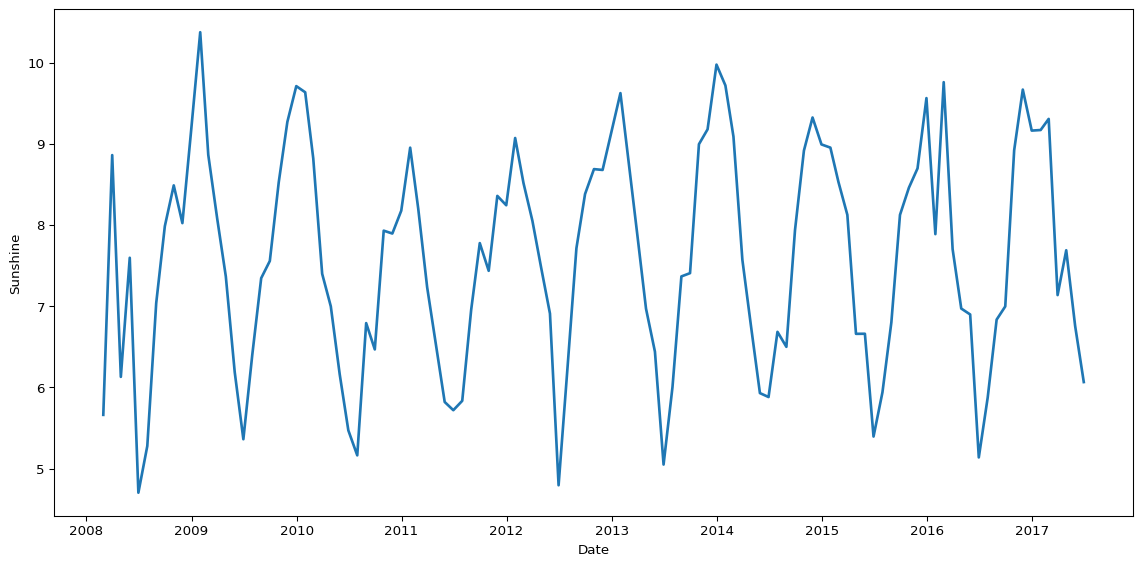

In [26]:
(
    big_cities
    # convert date to datetime object
    .assign(Date=pd.to_datetime(big_cities['Date']))
    # set date column as index
    .set_index('Date')
    # resample by month-end for monthly aggregations
    .resample('ME')
    # calculate mean sunshine per month
    .agg({'Sunshine': 'mean'})
    # convert month index back to column in dataframe
    .reset_index()
    # pass df object to seaborn lineplot
    .pipe(lambda df: sns.lineplot(data=df, x='Date', y='Sunshine', color="#1f77b4", linewidth=2))
)

plt.tight_layout()
plt.show()

Finally, we could combine two plots to look at how the average rainfall
and average sunshine both vary by month.

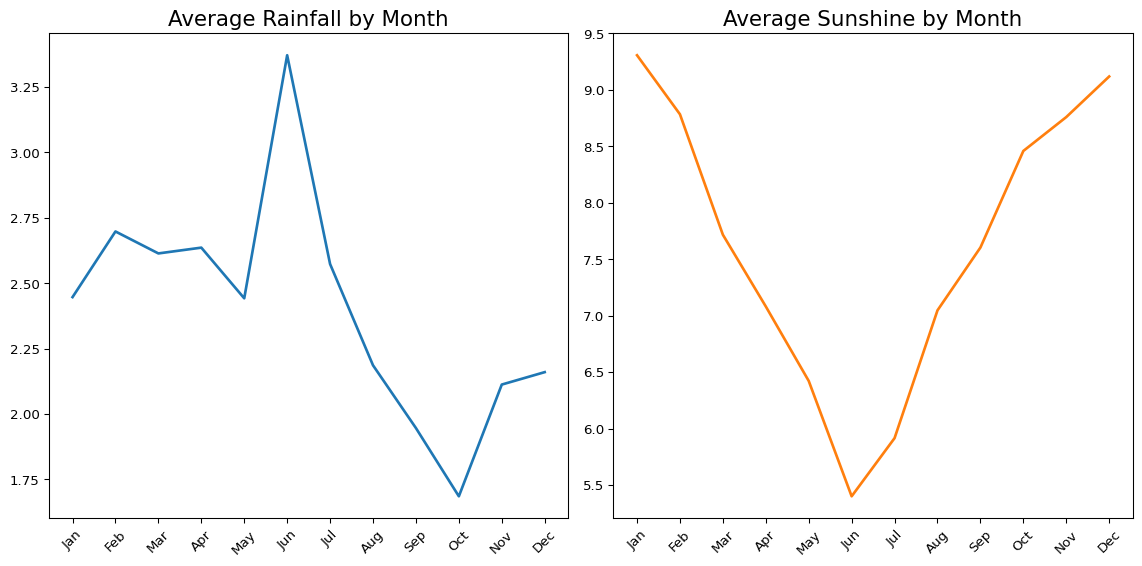

In [27]:
fig, axes = plt.subplots(1, 2)

(
    big_cities
    .assign(Date=pd.to_datetime(big_cities['Date']))
    .assign(Month=lambda x: x['Date'].dt.month)
    .groupby('Month')['Rainfall'].mean()
    .reset_index()
    .pipe(lambda df: sns.lineplot(data=df, x='Month', y='Rainfall', color="#1f77b4", linewidth=2, ax=axes[0]))
)

(
    big_cities
    .assign(Date=pd.to_datetime(big_cities['Date']))
    .assign(Month=lambda x: x['Date'].dt.month) 
    .groupby('Month')['Sunshine'].mean() 
    .reset_index()
    .pipe(lambda df: sns.lineplot(data=df, x='Month', y='Sunshine', color="#ff7f0e", linewidth=2, ax=axes[1]))
)

xticks = range(1, 13)
xticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for ax in axes:
    ax.set_xticks(xticks)  # Set ticks
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('')
axes[0].set_title('Average Rainfall by Month', fontsize=16)
axes[1].set_title('Average Sunshine by Month', fontsize=16)

plt.tight_layout()
plt.show()

## Exercises

Some of these questions are easily answered by scrolling up and finding
the answer in the output of the above code, however, the goal is to find
the answer using code. No one actually cares what the answer to any of
these questions is, it’s the process that matters!

**Remember, if you don’t know the answer, it’s okay to Google it (or
speak to others, including me, for help)!**

In [28]:
# import the dataset
df = pd.read_csv('data/weatherAUS.csv')

1.  What does the distribution of minimum daily temperatures look like
    in these cities? Are there any unusual patterns?

> **Solution**
>
> ``` python
> sns.histplot(big_cities["MinTemp"].dropna(), kde=True)
> plt.title("Distribution of MinTemp")
> plt.show()
> ```
>
> 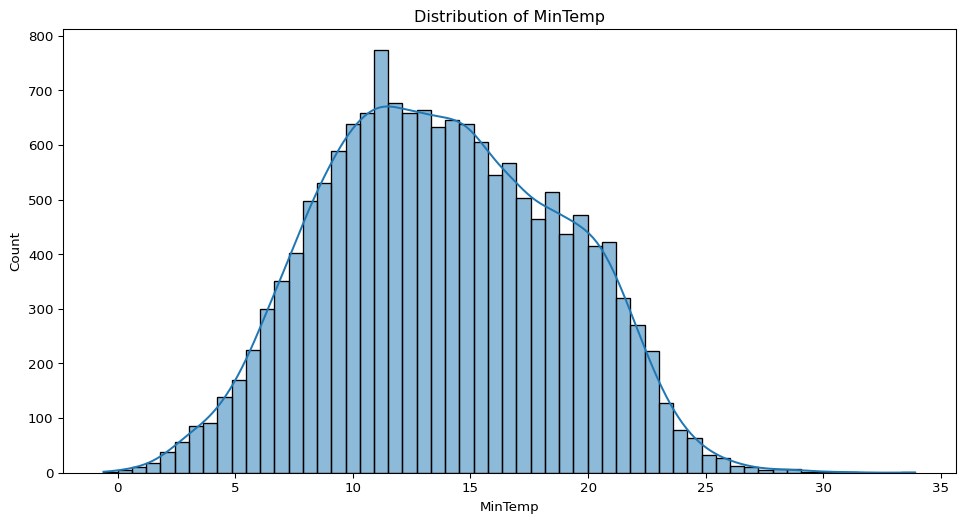

1.  Does the amount of sunshine vary depending on whether it rains the
    next day? Visualise this.

> **Solution**
>
> ``` python
> sns.boxplot(data=big_cities, x="RainTomorrow", y="Sunshine")
> plt.title("Sunshine by Rain Tomorrow")
> plt.show()
> ```
>
> 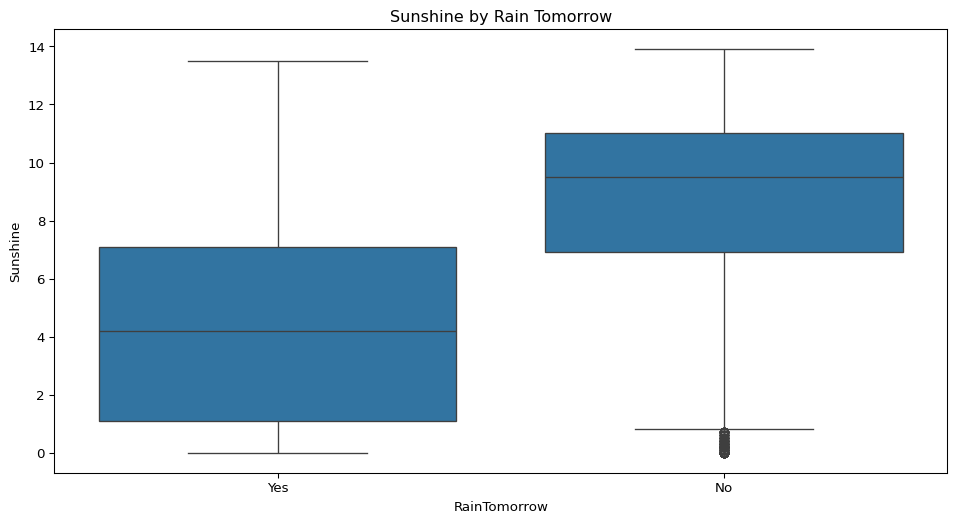

1.  How closely related are atmospheric pressure readings in the morning
    compared to the afternoon?

> **Solution**
>
> ``` python
> sns.scatterplot(data=big_cities, x="Pressure9am", y="Pressure3pm")
> plt.title("Pressure at 9am vs 3pm")
> plt.show()
> ```
>
> 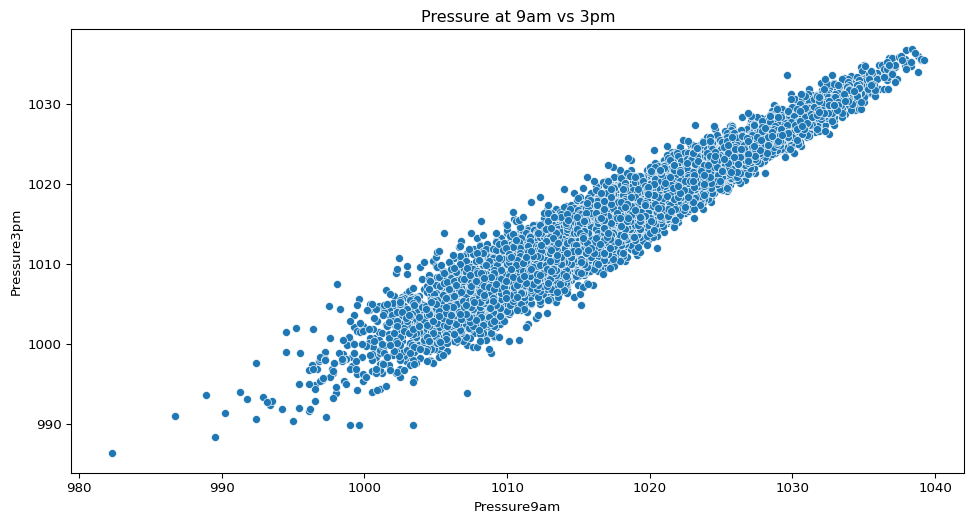

1.  How does humidity in the afternoon vary across the five cities? What
    can you infer from this?

> **Solution**
>
> ``` python
> sns.violinplot(data=big_cities, x="Location", y="Humidity3pm")
> plt.title("Humidity at 3pm by City")
> plt.show()
> ```
>
> 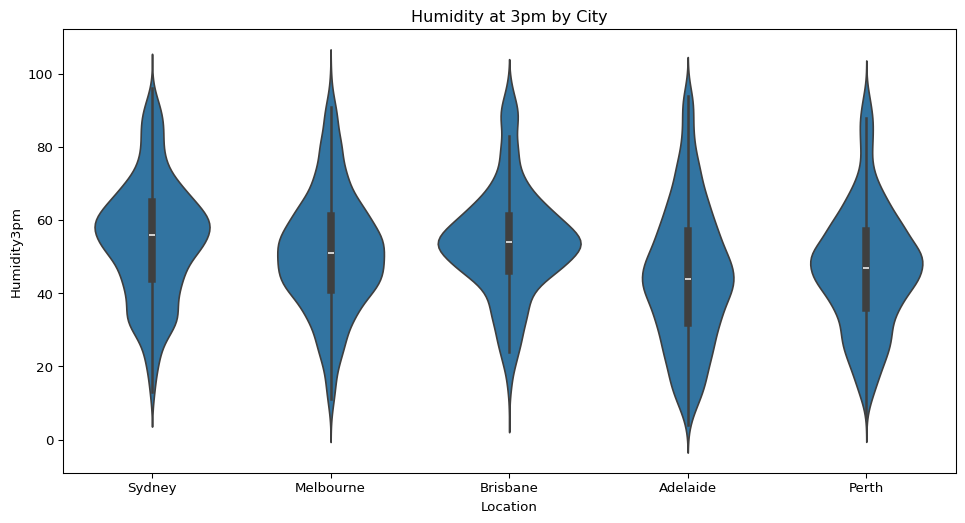

1.  Are days when rain is expected tomorrow more or less common in this
    dataset? Show the distribution.

> **Solution**
>
> ``` python
> sns.countplot(data=big_cities, x="RainTomorrow")
> plt.title("Rain Tomorrow Counts")
> plt.show()
> ```
>
> 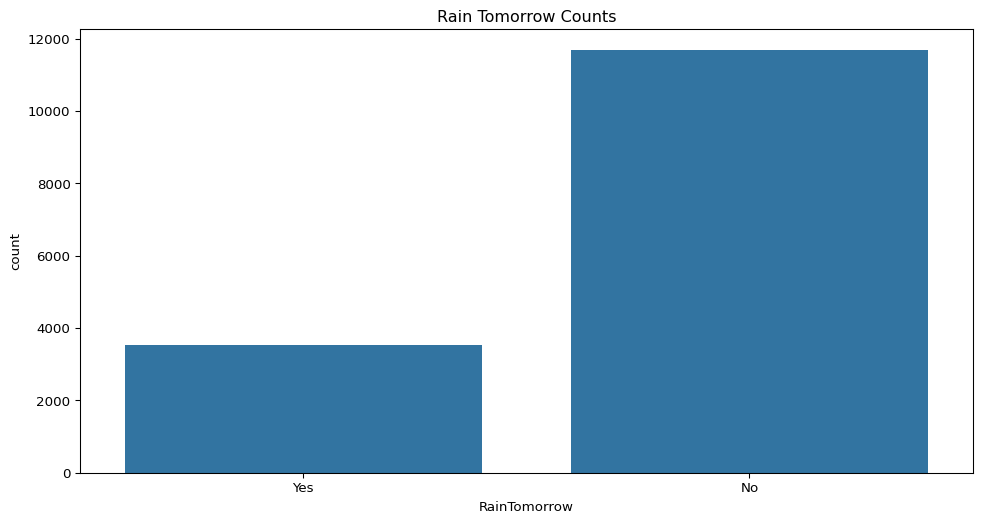

1.  Is there any relationship between afternoon temperature and
    humidity? Does this relationship change depending on whether it
    rains the next day?

> **Solution**
>
> ``` python
> sns.scatterplot(data=big_cities, x="Temp3pm", y="Humidity3pm", hue="RainTomorrow")
> plt.title("Temp vs Humidity at 3pm by Rain Tomorrow")
> plt.show()
> ```
>
> 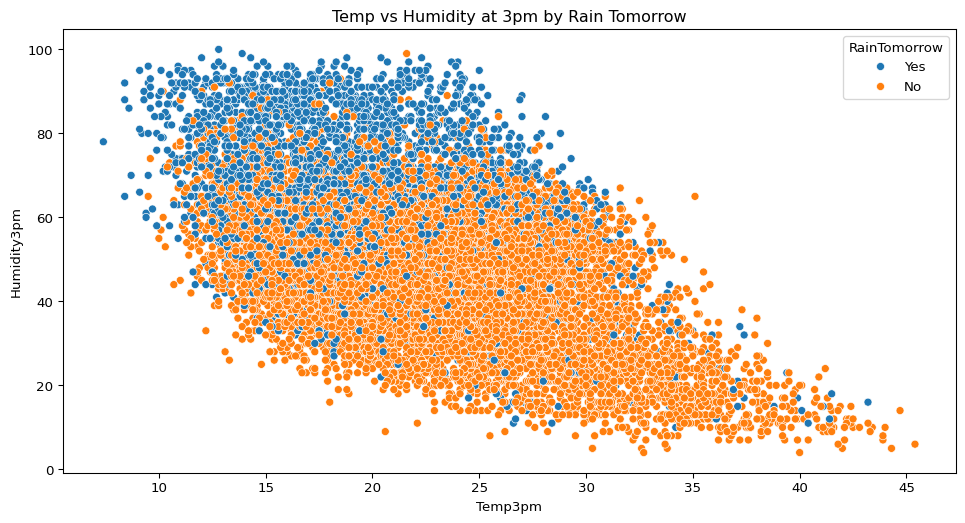

1.  How strongly are the different continuous variables in this dataset
    correlated with each other? Create a correlation matrix.

> **Solution**
>
> ``` python
> corr = big_cities.select_dtypes(include="number").corr().round(2)
> plt.figure(figsize=(10, 8))
> sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
> plt.title("Correlation Matrix")
> plt.show()
> ```
>
> 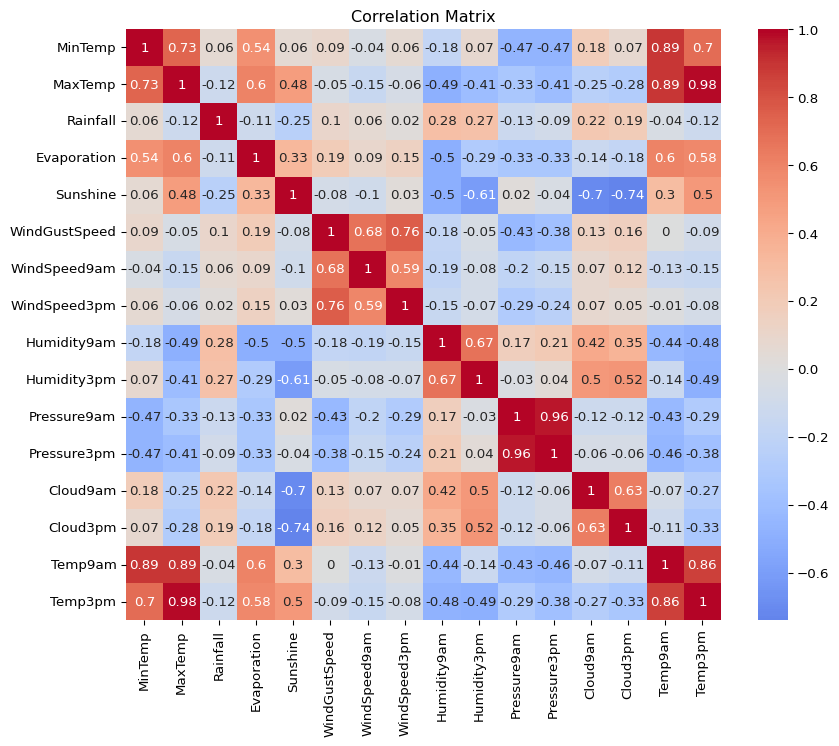

1.  Explore the relationships between rainfall, sunshine, and afternoon
    humidity across the cities. What patterns stand out?

> **Solution**
>
> ``` python
> sns.pairplot(big_cities, vars=["Rainfall", "Sunshine", "Humidity3pm"], hue="Location")
> plt.show()
> ```
>
> 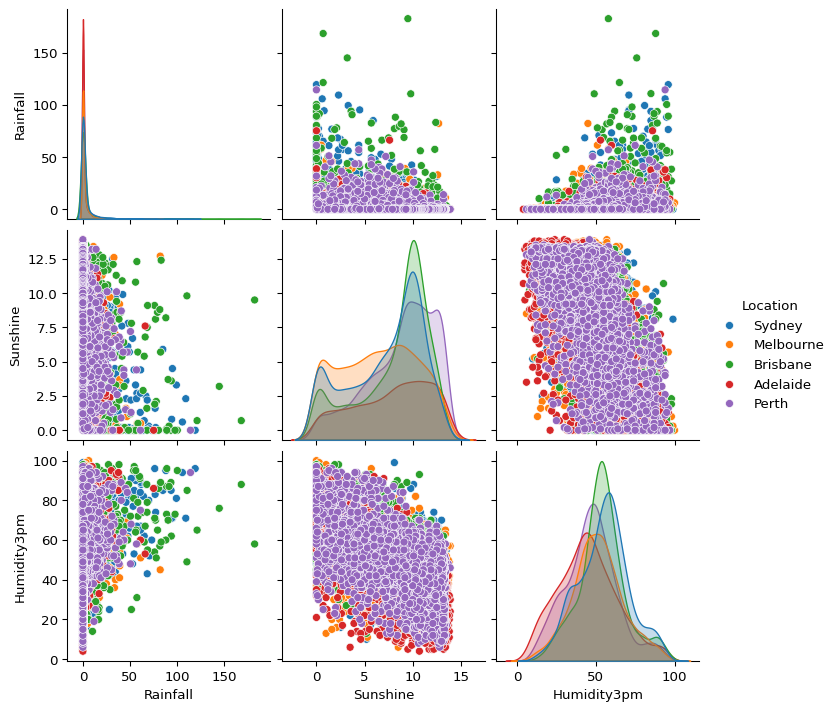

1.  How has the maximum temperature in Brisbane changed over time?
    Create a time series visualisation.

> **Solution**
>
> ``` python
> brisbane = big_cities.loc[big_cities["Location"] == "Brisbane"]
> brisbane['Date'] = pd.to_datetime(brisbane['Date'])
> brisbane_daily = brisbane.groupby("Date")["MaxTemp"].mean().reset_index()
>
> plt.figure(figsize=(12, 4))
> sns.lineplot(data=brisbane_daily, x="Date", y="MaxTemp")
> plt.title("Daily Max Temp in Brisbane")
>
> plt.show()
> ```
>
> 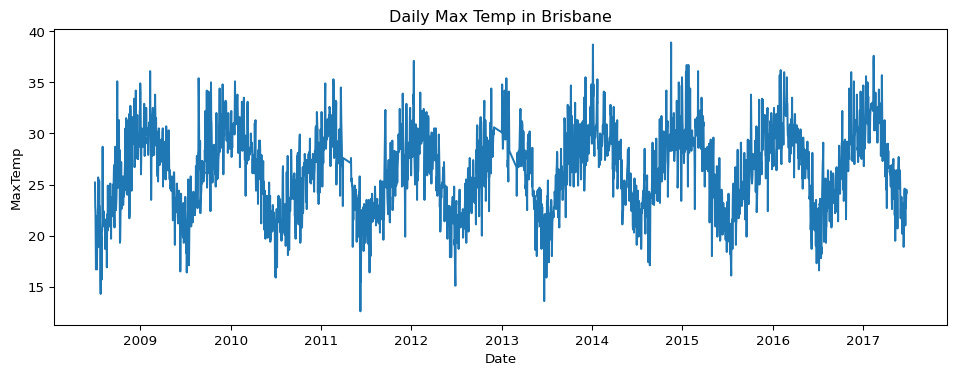

1.  What does the distribution of daily rainfall amounts look like? Is
    it skewed or symmetric?

> **Solution**
>
> ``` python
> sns.kdeplot(data=big_cities, x="Rainfall", fill=True)
> plt.title("Rainfall Distribution")
> plt.show()
> ```
>
> 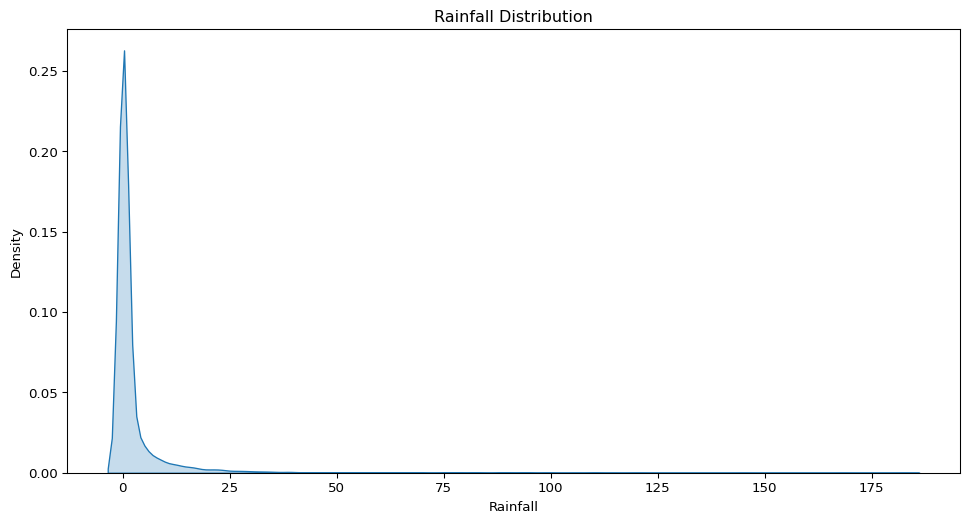

1.  How does the average morning wind speed compare across the five
    cities?

> **Solution**
>
> ``` python
> sns.barplot(data=big_cities, x="Location", y="WindSpeed9am", ci=None)
> plt.title("Average Morning Wind Speed by City")
> plt.show()
> ```
>
> 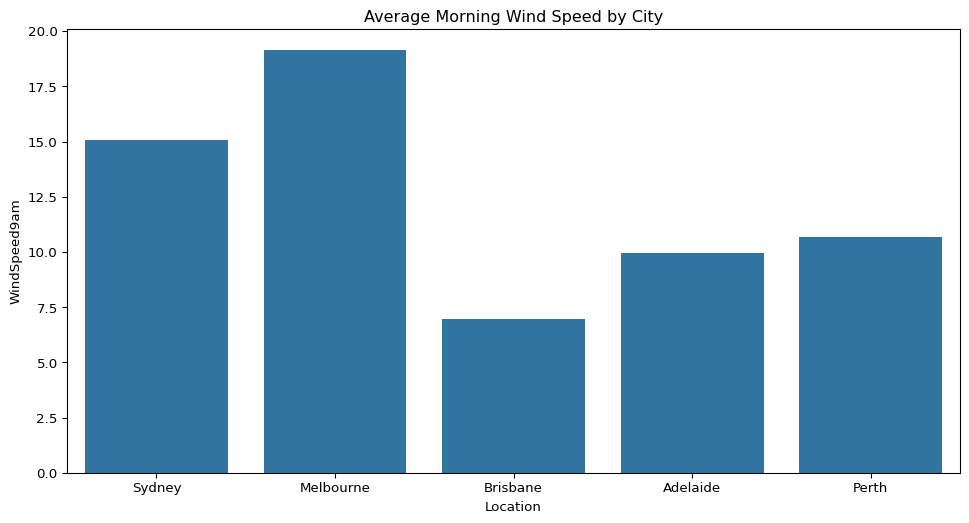

1.  In Perth, is there any visible relationship between the amount of
    sunshine and rainfall?

> **Solution**
>
> ``` python
> perth = big_cities.loc[big_cities["Location"] == "Perth"]
> sns.scatterplot(data=perth, x="Sunshine", y="Rainfall")
> plt.title("Sunshine vs Rainfall in Perth")
> plt.show()
> ```
>
> 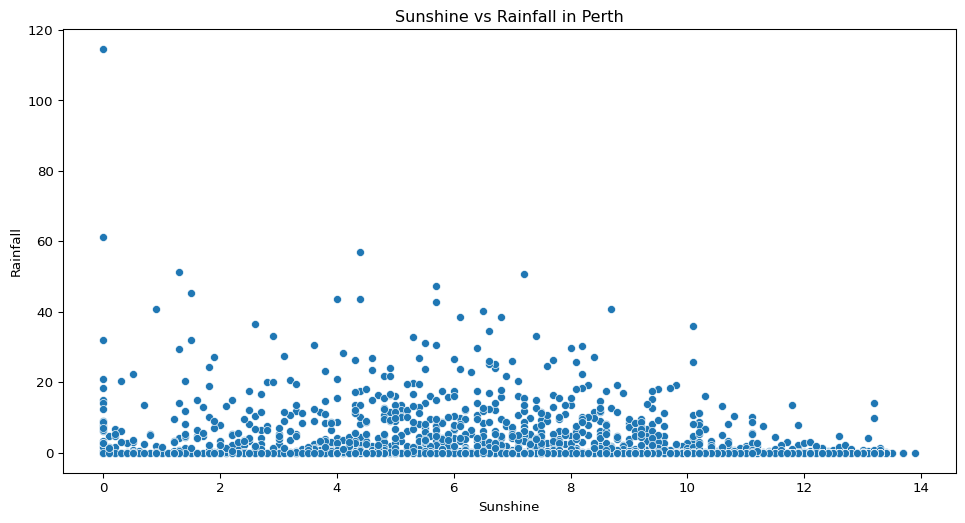